# Resources

- [odespy tutorial](http://hplgit.github.io/odespy/doc/pub/tutorial/odespy.pdf)
- [odespy api doc](http://hplgit.github.io/odespy/doc/api/odespy.html)

In [10]:
import numpy as np
import matplotlib.pyplot as plot

%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 10, 8

# Ambient state

In [11]:
from pycfd.reference.atmospheric_flow import stratification_profiles, saturation_calculation

ambient_stratification = stratification_profiles.Soong1973Dry()

g = ambient_stratification.g
R_d = ambient_stratification.gas_properties.R()
cp_d = ambient_stratification.gas_properties.cp()


Te = lambda z: ambient_stratification.temp(z)
p = ambient_stratification.p

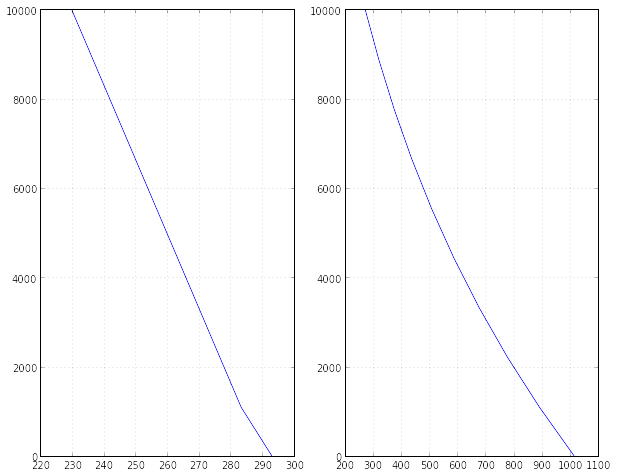

In [12]:
z_ = np.linspace(0., 10e3, 10.)

plot.subplot(121)
plot.plot(Te(z_), z_)
plot.grid(True)

plot.subplot(122)
plot.plot(p(z_)/100., z_)
plot.grid(True)

# Integration

In [16]:
mu = 0.0  # entrainment rate [1/m]
gamma = 0.5  # virtual mass coefficient [1]
D = 0.0  # drag coefficient [1]
Lv = 2.5008e6  # latent heat of vapourisation [J/kg]

def dwdz(z, r, w, T):
    """
    Also requires: environment temperature (density), so that buoyancy can be computed
    """
    
    B = (T-Te(z))/T
    
    return 1./w*(g/(1+gamma)*B - mu*w**2 - D*w**2/r)

def dTdz(z, r, w, T):
    Te_ = Te(z)

    return -g/cp_d - mu*(T - Te_)

def drdz(z, r, w, T, dwdz_, dTdz_):
  
    return r/2. *( (g/(R_d*T) + 1./T*dTdz_) - 1./w * dwdz_ + mu/r)

# r, w, T, q_v, q_r, q_l, q_i
def dFdz(F, z):
    r, w, T, q_v, q_r, q_l, q_i = F
    
    dwdz_ = dwdz(z, r, w, T)
    dTdz_ = dTdz(z, r, w, T)
    drdz_ = drdz(z, r, w, T, dwdz_, dTdz_)
    
    return [drdz_, dwdz_, dTdz_, 0., 0., 0., 0.,]

In [17]:
import odespy, numpy

RKFehlberg terminated at t=1827.25


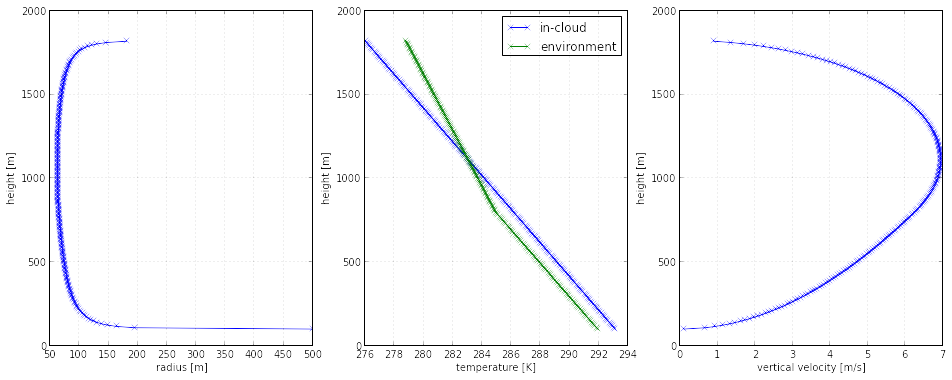

In [21]:
#solver = odespy.Vode(dFdz, rtol=0.0, atol=1e-6, adams_or_bdf='adams', order=10)

solver = odespy.RKFehlberg(dFdz, rtol=0.0, atol=1e-6,)

# r, w, T, q_v, q_r, q_l, q_i
w0 = 0.1
T0 = Te(0.0) + 0.2
solver.set_initial_condition([500.0, w0, T0, 0.00, 0., 0., 0.])

stopping_criterion = lambda F, z, k: F[k,1] <= 0.0 or F[k,2] > 300.

z_points = numpy.linspace(100., 4e3, 500)
F, z = solver.solve(z_points, stopping_criterion)

# often the last point seems to be bad...
F = F[:-1,]
z = z[:-1,]
    
r = F[:,0]
w = F[:,1]
T = F[:,2]

import matplotlib.pyplot as plot

plot.figure(figsize=(16,6))
plot.subplot(131)
plot.plot(r, z, marker='x')
plot.ylabel('height [m]')
plot.xlabel('radius [m]')
plot.grid(True)
plot.subplot(132)
plot.plot(T, z, marker='x', label='in-cloud')
plot.plot(Te(z), z, marker='x', label='environment')
plot.legend()
plot.xlabel('temperature [K]')
plot.ylabel('height [m]')
plot.grid(True)
plot.subplot(133)
plot.plot(w, z, marker='x')
plot.ylabel('height [m]')
plot.xlabel('vertical velocity [m/s]')
plot.grid(True)
show()